## Spam classifier

First, let's fetch the data:

In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_hard_ham.tar.bz2"  # for the homework, use: 	20030228_hard_ham.tar.bz2
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [2]:
fetch_spam_data()

Next, let's load all the emails:

In [3]:
HAM_DIR = os.path.join(SPAM_PATH, "hard_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [4]:
len(ham_filenames)

250

In [5]:
len(spam_filenames)

500

We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [6]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "hard_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [7]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [8]:
print(ham_emails[1].get_content().strip())

May 7, 2002


Dear rod-3ds@arsecandle.org:


Congratulations!  On behalf of Frito-Lay, Inc., we are pleased to advise you
 that you've won Fourth Prize in the 3D's(R) Malcolm in the Middle(TM)
 Sweepstakes.   Fourth Prize consists of 1 manufacturer's coupon redeemable at
 participating retailers for 1 free bag of 3D's(R) brand snacks (up to 7 oz.
 size), with an approximate retail value of $2.59 and an expiration date of
 12/31/02.

Follow these instructions to claim your prize:

1.	Print out this email message.

2.	Complete ALL of the information requested.  Print clearly and legibly.  Sign
 where indicated.

3.	If you are under 18 or otherwise under the legal age of majority in your
 state, your parent or legal guardian must co-sign where indicated below.

4.	Mail the completed and signed form to:  3D's(R) Malcolm in the Middle(TM)
 Sweepstakes, Redemption Center, PO Box 1520, Elmhurst IL 60126.  WE MUST
 RECEIVE THIS FORM NO LATER THAN MAY 28, 2002 IN ORDER TO SEND YOU THE PRIZE.

P

In [9]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [10]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [11]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [12]:
structures_counter(ham_emails).most_common()

[('text/html', 118),
 ('text/plain', 81),
 ('multipart(text/plain, text/html)', 43),
 ('multipart(text/html)', 2),
 ('multipart(text/plain, image/bmp)', 1),
 ('multipart(multipart(text/plain, text/html))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, image/png, image/png)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif, image/jpeg, image/gif, image/gif, image/gif, image/gif, image/gif, image/gif)',
  1),
 ('multipart(text/plain, text/plain)', 1)]

In [13]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.

Now let's take a look at the email headers:

In [14]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the `Subject` header:

In [15]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

Okay, before we learn too much about the data, let's not forget to split it into a training set and a test set:

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [17]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Let's see if it works. This is HTML spam:

In [18]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

Me and my friends have this brand new idea, a Live Webcam <a href="http://%31%30%31%31%30%31%31%31%30%31%31%31%31%30%31%30%31%30%31%30%31%30%31%31%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%31%30%31%30%31%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%30%31%31%30%30%30%31%30%31%31%30%31%31%31%30%31%30%31%30%31%30%31%30%31%30%30%30%31%31%30%31%30%31%30%31%31%30%31%30%31%30%31%30%31%31%30%31@%34%2E%34%37%2E%39%36%2E%31%34%31/msga.html"> Click Here <a/>
<br>
<br>
<br>
<font size="1">This is NOT SPAM - You have received this e-mail because 
at one time or another you entered the weekly draw at one of
our portals or FFA sites. We comply with all proposed and current laws 
on commercial e-mail under (Bill s. 1618 TITLE III passed by the 105th 
Congress).
 If you have received this e-mail in error, we apologize for the 
inconvenience and ask that you remove

And this is the resulting plain text:

In [19]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")

Me and my friends have this brand new idea, a Live Webcam  HYPERLINK  Click Here
This is NOT SPAM - You have received this e-mail because
at one time or another you entered the weekly draw at one of
our portals or FFA sites. We comply with all proposed and current laws
on commercial e-mail under (Bill s. 1618 TITLE III passed by the 105th
Congress).
 If you have received this e-mail in error, we apologize for the
inconvenience and ask that you remove yourself.
Click   HYPERLINK Here to Unsubscribe
fysibvcgjyuwinmyvbpjtaebsymyukbrkn
 ...


Great! Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:

In [20]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [21]:
print(email_to_text(sample_html_spam)[:100], "...")

Me and my friends have this brand new idea, a Live Webcam  HYPERLINK  Click Here
This is NOT SPAM -  ...


Let's throw in some stemming! For this to work, you need to install the Natural Language Toolkit ([NLTK](http://www.nltk.org/)). It's as simple as running the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install nltk`

In [22]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Error: stemming requires the NLTK module.


We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library. You can install it with the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install urlextract`

In [23]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

Error: replacing URLs requires the urlextract module.


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails:

In [25]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'of': 30, 'to': 28, 'the': 28, 'and': 20, 'this': 17, 'your': 14, 'in': 12, 'we': 12, 'a': 11, 'you': 11, 'kabila': 9, 'congo': 8, 'NUMBER': 8, 'is': 8, 'my': 8, 'us': 8, 'country': 7, 'i': 7, 'president': 7, 'out': 6, 'by': 5, 'laurent': 5, 'our': 5, 'as': 5, 'fund': 5, 'with': 5, 'from': 4, 'col': 4, 'democratic': 4, 'republic': 4, 'code': 4, 'that': 4, 'money': 4, 'security': 4, 'for': 4, 'who': 4, 'move': 4, 'will': 4, 'are': 4, 'linux': 4, 'michael': 3, 'bundu': 3, 'intl': 3, 'access': 3, 'email': 3, 'please': 3, 'me': 3, 'need': 3, 'one': 3, 'his': 3, 'were': 3, 'late': 3, 'then': 3, 'other': 3, 'here': 3, 'can': 3, 'assist': 3, 'have': 3, 'not': 3, 'through': 3, 'worked': 3, 'information': 3, 'be': 3, 'dial': 3, 'ie': 3, 'tel': 2, 'no': 2, 'rediffmail': 2, 'com': 2, 'assistance': 2, 'so': 2, 'trust': 2, 'foreign': 2, 'partner': 2, 'may': 2, 'but': 2, 'indulgence': 2, 'view': 2, 'it': 2, 'name': 2, 'aides': 2, 'military': 2, 'some': 2, 'group': 2, 'when': 2, 'imme

This looks about right!

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [26]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [27]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.float64'>'
	with 33 stored elements in Compressed Sparse Row format>

In [28]:
X_few_vectors.toarray()

array([[556.,  30.,  28.,  12.,  11.,  20.,  11.,  28.,   8.,  14.,  17.],
       [704.,  30.,  24.,  19.,  14.,  14.,  21.,  48.,  24.,   9.,  16.],
       [746.,  13.,  19.,  10.,  15.,  17.,  17.,  21.,  54.,   8.,   7.]])

What does this matrix mean? Well, the 64 in the third row, first column, means that the third email contains 64 words that are not part of the vocabulary. The 1 next to it means that the first word in the vocabulary is present once in this email. The 2 next to it means that the second word is present twice, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "of", the second word is "and", etc.

In [29]:
vocab_transformer.vocabulary_

{'of': 1,
 'to': 2,
 'in': 3,
 'a': 4,
 'and': 5,
 'you': 6,
 'the': 7,
 'NUMBER': 8,
 'your': 9,
 'this': 10}

We are now ready to train our first spam classifier! Let's transform the whole dataset:

In [30]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV] END ................................ score: (test=0.905) total time=   0.0s
[CV] END ................................ score: (test=0.945) total time=   0.0s
[CV] END ................................ score: (test=0.925) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


0.9250000000000002

Over 98.7%, not bad for a first try! :) However, remember that we are using the "easy" dataset. You can try with the harder datasets, the results won't be so amazing. You would have to try multiple models, select the best ones and fine-tune them using cross-validation, and so on.

But you get the picture, so let's stop now, and just print out the precision/recall we get on the test set:

In [32]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 93.14%
Recall: 96.94%


In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid2 = GridSearchCV(SVC(), param_grid, cv=10)
grid2.fit(X_train_transformed, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [34]:
print(grid2.best_params_)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [35]:
X_test_transformed = preprocess_pipeline.transform(X_test)

SVC_clf = SVC(C= 1000, gamma = 0.0001, kernel = 'rbf')
SVC_clf.fit(X_train_transformed, y_train)

y_pred = SVC_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 95.05%
Recall: 97.96%


In [36]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 0)
grid_param = {'max_depth': [3, 5, 7, 9, 11, 15]}
dt_grid = GridSearchCV(dt, grid_param, cv = 10)
dt_grid.fit(X_train_transformed, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, 7, 9, 11, 15]})

In [37]:
print("Best Parameters for Decision Tree Classifier: ", dt_grid.best_params_)

Best Parameters for Decision Tree Classifier:  {'max_depth': 5}


In [38]:
X_test_transformed = preprocess_pipeline.transform(X_test)

dt_clf = DecisionTreeClassifier(max_depth = 5)
dt_clf.fit(X_train_transformed, y_train)

y_pred = dt_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 89.52%
Recall: 95.92%


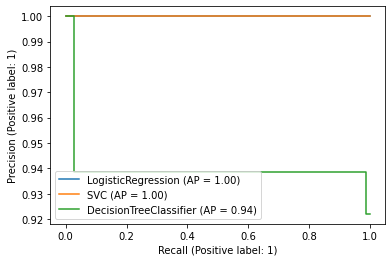

In [39]:
import matplotlib.pyplot as plt
from sklearn import metrics
classifiers = [log_clf, SVC_clf,dt_clf]
ax = plt.gca()
for i in classifiers:
    metrics.plot_precision_recall_curve(i, X_train_transformed, y_train, ax=ax)

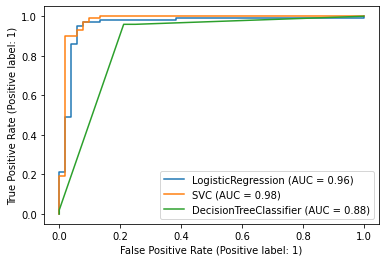

In [40]:
ax = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test_transformed, y_test, ax=ax)